In [1]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [3]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df

    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [4]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = max(local_max(df)['Edis'])
    min_val = min(local_min(df)['Edis'])
    min_val_idx = local_min(df)[local_min(df)['Edis'] == min_val].index[0]
    min_length = local_min(df).loc[min_val_idx, 'cell_length']
    
    max_val_idx = local_max(df)[local_max(df)['Edis'] == max_val].index[0]
    
    # equation of line between two points (x1, y1) and (x2, y2)
    x1 = local_max(df).loc[max_val_idx, 'cell_length'] 
    x2 = df['cell_length'].iloc[-1]

    y1 = max_val
    y2 = abs_max
    # print(min_length)
    
    # Finding the maximum slope
    max_slope = float('-inf')
    best_x2 = x2
    best_y2 = y2
    
    # Get the dataframe points after x1
    points_after_x1 = df[df['cell_length'] > x1][['cell_length', 'Edis']]
    
    # Iterate through all points after x1
    for idx, row in points_after_x1.iterrows():
        temp_x2 = row['cell_length']
        temp_y2 = row['Edis']
        temp_slope = (y1 - temp_y2) / (x1 - temp_x2)
        
        if temp_slope > max_slope:
            max_slope = temp_slope
            best_x2 = temp_x2
            best_y2 = temp_y2
    
    x2 = best_x2
    y2 = best_y2
    slope = max_slope
    intercept = y2 - slope * x2

    if y2 < y1:
        slope = 0
        intercept = y1

    #value of y when x = min_length
    y_at_min_length = slope * min_length + intercept

    diff = abs(min_val - y_at_min_length)
    return diff


In [5]:
from pymatgen.core import Structure

In [6]:
#list all folders inside li_d3s
li_d3s = os.listdir("d3_calcs")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['Cu']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'Cu' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')
    

Reading d3_calcs/Cu3Sb_20900/Cu3Sb_20900.csv
Material ID: mp-20900
Composition Cu6 Sb2
diff per toal sites 0.005068656024186609
diff per cation sites 0.006758208032248812
-----------------------------------
Reading d3_calcs/CuBr_23227/CuBr_23227.csv
Material ID: mp-23227
No local max found
0
No local max found
0
No local max found
0
No local max found
0
No local max found
0
No local max found
0
No local max found
0
No local max found
0
Composition Cu2 Br2
diff per toal sites 0.0
diff per cation sites 0.0
-----------------------------------
Reading d3_calcs/Ti2Cu_1192264/Ti2Cu_1192264.csv
Material ID: mp-1192264
Composition Ti16 Cu8
diff per toal sites 0.012733002663800798
diff per cation sites 0.03819900799140239
-----------------------------------
Reading d3_calcs/LiCu3_1185338/LiCu3_1185338.csv
Material ID: mp-1185338
Composition Li2 Cu6
diff per toal sites 0.011480842426287387
diff per cation sites 0.015307789901716516
-----------------------------------
Reading d3_calcs/CuPt3_12134

### for individual elements

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df

Total structures analysed = 401


,Symbol,Structure,Total Sites,Cation Sites,Counter Ion Sites,Diff Energy,Diff per Total Sites,Diff per Cation Sites,Diff per Counter Ion Sites,Volume,mid,Composition
0,Sb,"(Cu, Sb)",8,6.0,2.0,0.040549,0.005069,0.006758,0.020275,119.023124,20900,Cu6 Sb2
1,Br,"(Cu, Br)",4,2.0,2.0,0.000000,0.000000,0.000000,0.000000,88.455100,23227,Cu2 Br2
2,Ti,"(Ti, Cu)",24,8.0,8.0,0.305592,0.012733,0.038199,0.038199,375.621023,1192264,Ti16 Cu8
3,Li,"(Li, Cu)",8,6.0,6.0,0.091847,0.011481,0.015308,0.015308,92.574593,1185338,Li2 Cu6
4,Pt,"(Cu, Pt)",4,1.0,3.0,0.009293,0.002323,0.009293,0.003098,587.894709,1213433,Cu1 Pt3
...,...,...,...,...,...,...,...,...,...,...,...,...
395,Zr,"(Zr, Cu)",6,4.0,4.0,0.066137,0.011023,0.016534,0.016534,91.176472,1072655,Zr2 Cu4
396,Al,"(Al, Cu)",4,1.0,1.0,0.022770,0.005692,0.022770,0.022770,60.427848,1183161,Al3 Cu1
397,S,"(Cu, S)",2,1.0,1.0,0.000907,0.000453,0.000907,0.000907,34.348226,760381,Cu1 S1
398,I,"(Cu, I)",4,2.0,2.0,0.001610,0.000402,0.000805,0.000805,115.417956,23306,Cu2 I2


### Thougest part is to make the Feature functions data 


In [8]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [9]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'Cu')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['mid'] = results_df['mid'][cnt]

    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

Sb
Cu3Sb
Br
CuBr
Ti
Ti2Cu
Li
LiCu3
Pt
CuPt3
O
Cu4O3
Te
CuTe
In
InCu
O
Cu2O3
As
Cu3As4
Mg
Mg3Cu
I
CuI
S
CuS2
La
LaCu4
O
CuO
Se
Cu17Se10
Te
Cu3Te2
Gd
GdCu6
Zr
Zr2Cu
Tb
Tb6Cu23
F
CuF2
I
Cu16I19
S
Cu2S
F
Cu3F
Hf
HfCu3
Au
CuAu3
Pd
Cu3Pd
Te
CuTe
Mg
Mg15Cu
As
Cu3As
S
CuS
Mg
MgCu3
I
Cu14I19
N
CuN
Se
Cu2Se
Ni
Cu3Ni
Te
CuTe2
Se
Cu9Se5
Sc
ScCu3
Te
Cu2Te
Zr
ZrCu
In
In3Cu
Ga
GaCu2
Se
Cu25Se26
S
CuS2
N
Cu3N
Pd
Cu4Pd
Ce
CeCu6
I
CuI
Pd
CuPd
O
CuO2
N
Cu10N3
S
Cu11S20
Sb
Cu3Sb
Te
CuTe
Se
Cu13Se8
Zn
ZnCu3
Zn
ZnCu2
Fe
Fe3Cu
Ge
Cu3Ge
Li


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

LiCu3
Er
ErCu5
O
Cu3O4
N
Cu3N
Zn
ZnCu3
Cd
CdCu2
N
CuN8
Pu
PuCu2
Se
CuSe
Sn
CuSn3
N
Cu3N
Mg
Mg2Cu
Cl
Cu3Cl
S
Cu3S2
O
CuO
V
V3Cu
In
InCu3
S
CuS
Fe
FeCu4
Ag
Cu3Ag
Ca
CaCu
As
Cu2As
Sn
Cu3Sn
O
CuO2
C
CuC6
S
CuS2
Ga
GaCu4
Al
Al2Cu
Br
CuBr2
I
CuI
Yb
YbCu2
Br
CuBr
Sn
Cu5Sn4
Mg
Mg3Cu
Ge
Cu5Ge2
Si
Cu3Si
Be
BeCu
Se
Cu2Se
S
Cu2S
Cd
CdCu3
Ni
CuNi
I
CuI4
O
Cu3O4
Lu
Lu6Cu23
Eu
EuCu
Cl
CuCl
Pr
PrCu6
As
Cu9As4
Sn
Cu10Sn3
Bi
CuBi
B
CuB5
B
CuB5
Fe
FeCu3
Ag
CuAg3
Te
Cu3Te
Al
AlCu3
In
In4Cu9
In
In9Cu11
Sn
CuSn3
P
Cu3P
N
CuN3
Au
CuAu3
N
Cu3N
P
Cu3P
Se
Cu19Se11
Se
Cu2Se
I
CuI
Sb
Cu3Sb
H
CuH
Dy
DyCu7
N
Cu3N
Zr
Zr3Cu
Sc
ScCu3
N
CuN3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

As
Cu3As
As
Cu4As
Cd
Cd5Cu2
Al
AlCu
Ce
CeCu
Au
CuAu
O
CuO
Se
CuSe
As
Cu3As
S
Cu2S
In
In3Cu
Cl
CuCl3
Mn
MnCu3
Pd
CuPd
Zr
Zr2Cu
Dy
Dy6Cu23
Tb
TbCu5
Se
Cu9Se8
Mn
Mn4Cu
O
Cu8O
Yb
Yb3Cu
S
Cu2S
In
In9Cu11
Sn
Cu81Sn22
Dy
DyCu5
O
CuO
Al
AlCu3
Au
CuAu3
N
CuN
Mg
Mg3Cu
S
Cu11S16
Se
CuSe
Th
Th2Cu
I
CuI4
Ti
Ti2Cu3
Pb
CuPb3
Li
LiCu3
O
CuO2
N
Cu3N
Si
Cu7Si6
Se
Cu29Se19
Nd
NdCu6
O
Cu3O2
O
Cu4O3
S
CuS2
Se
Cu2Se
Ce
Ce3Cu
Hf
HfCu3
S
Cu2S
Hg
Cu7Hg6
Al
AlCu4
Tl
Tl3Cu
I
CuI
Y
YCu2
Zn
ZnCu
Al
Al3Cu2
V
V3Cu
Mg
Mg4Cu
As
Cu3As
S
CuS2
Ge
Cu3Ge
Sr
Sr3Cu
O
Cu2O3
P
Cu3P
Cl
CuCl
S
Cu9S5
N


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

CuN
O
CuO
Se
CuSe2
I
CuI
O
Cu9O13
Sn
Cu3Sn
Zr
ZrCu
Ce
Ce3Cu
Ge
CuGe3
Na
NaCu
K
K3Cu
S
Cu9S5
Pd
CuPd3
Ti
TiCu3
Mg
Mg2Cu
Br
CuBr
Al
Al4Cu15
Al
Al2Cu
Pd
Cu3Pd2
O
Cu8O7
Ge
CuGe3
Eu
Eu2Cu
S
Cu9S16
F
CuF2
H
CuH
Mg
MgCu
N
CuN
Fe
Fe3Cu
O
Cu6O
Nd
Nd3Cu
I
CuI2
Zn
ZnCu
Ga
GaCu2
Fe
FeCu
Se
Cu4Se3
Ge
CuGe3
O
Cu8O
Ga
GaCu3
I
CuI
Zr
ZrCu
Ce
CeCu5
Na
NaCu3
Ti
TiCu
Cl
CuCl
Au
CuAu
La
LaCu6
Sm
SmCu
Sm
SmCu6
O
CuO2
Te
CuTe2
Ti
Ti2Cu3
I
CuI2
Se
Cu27Se20
Th
Th2Cu
U
UCu5
S
Cu2S
S
Cu2S
Zr
ZrCu3
Cl
CuCl4
Br
CuBr2
As
CuAs2
Se
CuSe
As
Cu3As
W
Cu3W
Ni
CuNi
Cl
CuCl
Ga
GaCu3
Y
YCu2
Pr
PrCu6
Y
Y2Cu3
Sn
Cu10Sn3
Se
Cu9Se5
Pd
Cu3Pd
Te
CuTe
Hg
Cu7Hg6
O
Cu2O3
Ta
Ta3Cu
S
Cu18S11
Sn
Cu41Sn11
O
Cu64O
Mg
Mg5Cu
As
Cu3As4
Mg
MgCu5
Sn
Cu6Sn5
N
Cu3N
Sn


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

Cu3Sn
Ti
Ti3Cu
U
U3Cu
Ge
Cu3Ge
Na
NaCu3
As
Cu3As
Se
Cu2Se
Be
Be3Cu
Pu
PuCu6
I
CuI
Rh
Cu3Rh
Ni
CuNi
S
Cu2S
Sn
Cu10Sn3
Hg
Cu7Hg6
Br
CuBr2
O
CuO2
As
CuAs2
As
Cu5As2
O
Cu5O7
Sn
CuSn
Fe
FeCu3
S
Cu9S5
O
CuO
Ga
Ga3Cu
Se
Cu2Se
O
CuO2
In
In2Cu
Nd
NdCu6
Nb
Nb3Cu
O
CuO
P
Cu3P
As
CuAs
Sb
Cu10Sb3
Na
Na3Cu
In
In3Cu7
In
In2Cu
Sb
Cu11Sb3
Ga
GaCu3
Rh
Cu3Rh
N
CuN6
Mg
Mg7Cu
Sn
Cu5Sn4
S
CuS
Ge
Cu5Ge2
Cl
CuCl2
S
CuS
Be
Be3Cu
Np
Np3Cu
Cl
CuCl2
N
Cu2N
Rh
CuRh


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

Cd
CdCu2
Zr
ZrCu
S
Cu2S
In
InCu2
Br
CuBr
Au
CuAu4
Sn
Cu19Sn16
Se
Cu9Se5
Si
Cu7Si2
Cl
CuCl2
As
Cu2As3
Co
Co3Cu
Se
Cu9Se8
Al
AlCu3
Br
CuBr
Li
Li3Cu
O
Cu8O7
O
CuO
O
CuO2
As
CuAs2
Tl
Tl3Cu
Ho
HoCu5
O
Cu2O3
Au
Cu4Au
Sb
Cu3Sb
Ni
CuNi3
S
Cu2S
Pm
Pm3Cu
Si
Cu3Si
O
Cu8O7
Fe
Fe3Cu
F
CuF
Pb
CuPb3
Ti
Ti5Cu2
La
LaCu6
Sn
Cu3Sn
Se
Cu2Se
As
Cu3As
Gd
GdCu
Y
YCu
S
Cu39S20
Cr
Cr3Cu
Ni
CuNi3
Pr
Pr3Cu
As
CuAs
Zr
ZrCu5
Mg
MgCu
Ba
BaCu13


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

Ru
Cu3Ru
O
CuO2
O
CuO2
N
CuN
Sb
Cu2Sb
S
Cu2S
Te
Cu7Te4
Cl
CuCl
Ru
CuRu3
Al
Al3Cu
Zr
ZrCu2
Al
Al3Cu
S
CuS
I
CuI
Zn
Zn3Cu


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15414/1615697561.py:41: SettingWith

In [10]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,mid,Reduced Formula
0,Sb,121.760000,206.0,2.05,8.640,1.070,43.0000,5.068656,6.758208,0.750000,0.250000,0.020275,0.000341,0.340684,Pmmn,59,8,20900,Cu3Sb
1,Br,79.900000,183.0,2.96,11.814,3.365,21.0000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,P6_3/mmc,194,4,23227,CuBr
2,Ti,47.867000,187.0,1.54,6.828,0.079,100.0000,12.733003,38.199008,0.333333,0.333333,0.038199,0.000814,0.813565,Fd-3m,227,24,1192264,Ti2Cu
3,Li,7.000000,182.0,0.98,5.392,0.618,164.1125,11.480842,15.307790,0.750000,0.750000,0.015308,0.000992,0.992138,P6_3/mmc,194,8,1185338,LiCu3
4,Pt,195.080000,209.0,2.28,9.000,2.128,48.0000,2.323268,9.293072,0.250000,0.750000,0.003098,0.000016,0.015807,Cmmm,65,4,1213433,CuPt3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Zr,91.220000,186.0,1.33,6.634,0.426,112.0000,11.022797,16.534195,0.666667,0.666667,0.016534,0.000725,0.725371,Cmcm,63,6,1072655,ZrCu2
396,Al,26.981538,184.0,1.61,5.986,0.441,57.8000,5.692486,22.769943,0.250000,0.250000,0.022770,0.000377,0.376812,Pm-3m,221,4,1183161,Al3Cu
397,S,32.070000,180.0,2.58,10.360,2.077,19.4000,0.453490,0.906981,0.500000,0.500000,0.000907,0.000026,0.026405,F-43m,216,2,760381,CuS
398,I,126.904500,198.0,2.66,10.451,3.059,32.9000,0.402432,0.804865,0.500000,0.500000,0.000805,0.000014,0.013947,R-3m,166,4,23306,CuI


In [11]:
all_props_df.to_csv('all_props_new.csv', index=False)

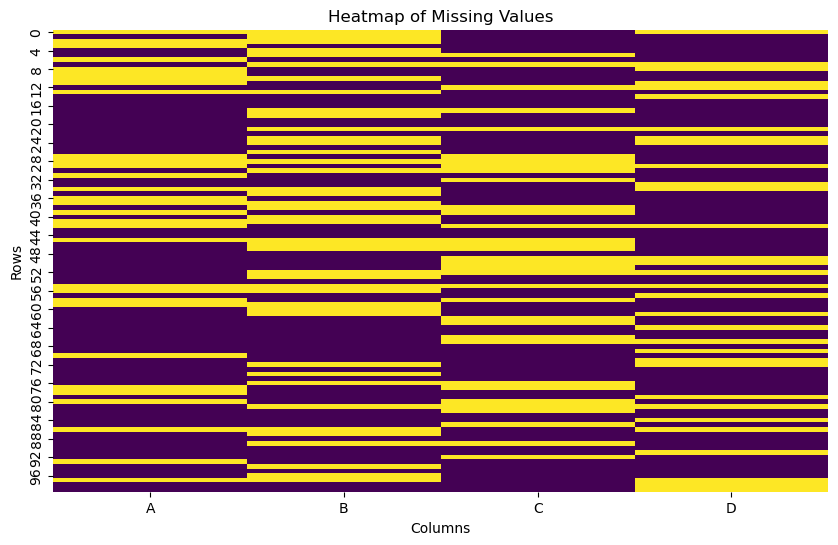

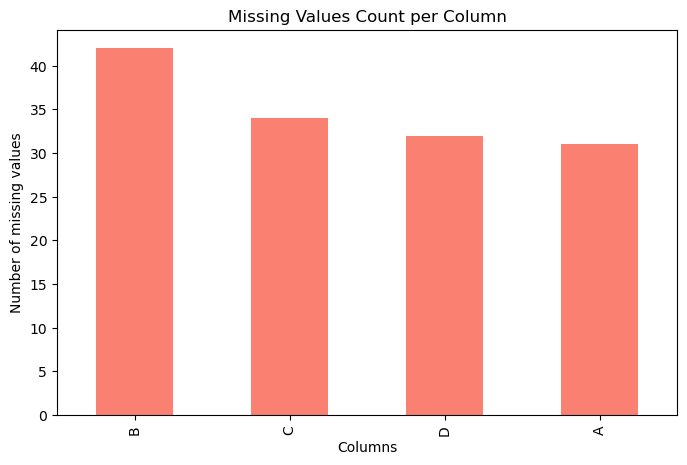

In [12]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [13]:
all_props_df.fillna(0, inplace=True)


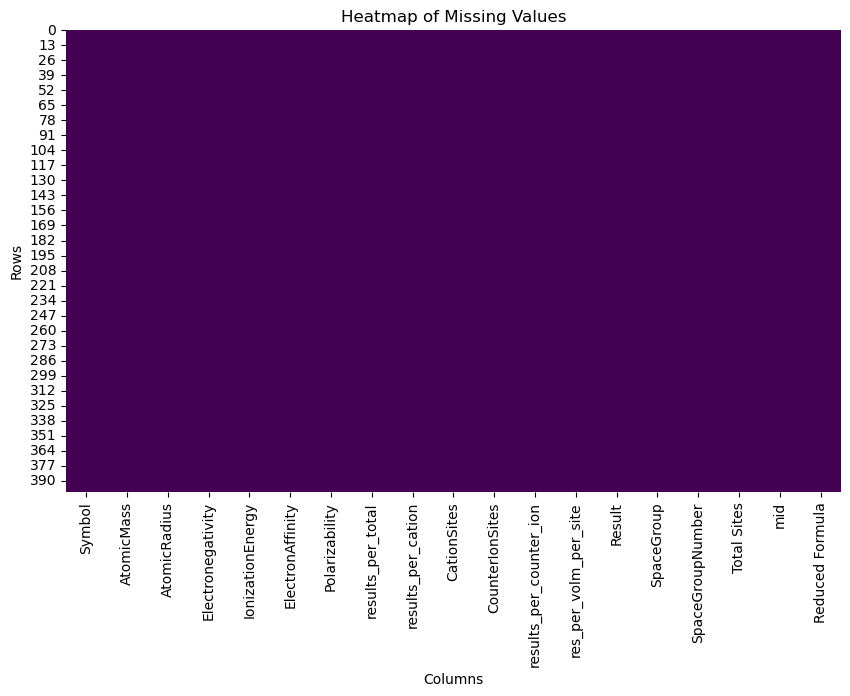

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [15]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

FileNotFoundError: [Errno 2] No such file or directory: 'all_props.csv'